### MobileNet

In [ ]:
"""内容源自https://blog.csdn.net/weixin_44791964"""

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape,Conv2D,DepthwiseConv2D,Input,Dropout,GlobalAveragePooling2D,Dense,BatchNormalization,Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [2]:


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x


def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    x = Conv2D(filters, kernel,
               padding='same',
               use_bias=False,
               strides=strides,
               name='conv1')(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    return Activation(relu6, name='conv1_relu')(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters,
                          depth_multiplier=1, strides=(1, 1), block_id=1):

    x = DepthwiseConv2D((3, 3),
                        padding='same',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(inputs)

    x = BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1),
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)

def relu6(x):
    return K.relu(x, max_value=6)


In [3]:
def MobileNet(input_shape=[224,224,3],
              depth_multiplier=1,
              dropout=1e-3,
              classes=1000):


    img_input = Input(shape=input_shape)

    # 224,224,3 -> 112,112,32  
    x = _conv_block(img_input, 32, strides=(2, 2))
    # 112,112,32 -> 112,112,64
    x = _depthwise_conv_block(x, 64, depth_multiplier, block_id=1)


    # 112,112,64 -> 56,56,128
    x = _depthwise_conv_block(x, 128, depth_multiplier,
                              strides=(2, 2), block_id=2)
    # 56,56,128 -> 56,56,128
    x = _depthwise_conv_block(x, 128, depth_multiplier, block_id=3)


    # 56,56,128 -> 28,28,256
    x = _depthwise_conv_block(x, 256, depth_multiplier,
                              strides=(2, 2), block_id=4)
    # 28,28,256 -> 28,28,256
    x = _depthwise_conv_block(x, 256, depth_multiplier, block_id=5)
    

    # 28,28,256 -> 14,14,512
    x = _depthwise_conv_block(x, 512, depth_multiplier,
                              strides=(2, 2), block_id=6)
    # 14,14,512 -> 14,14,512
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, depth_multiplier, block_id=11)

    # 14,14,512 -> 7,7,1024
    x = _depthwise_conv_block(x, 1024, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, depth_multiplier, block_id=13)

    # 7,7,1024 -> 1,1,1024
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1024), name='reshape_1')(x)
    x = Dropout(dropout, name='dropout')(x)

    x = Conv2D(classes, (1, 1),padding='same', name='conv_preds')(x)
    x = Activation('softmax', name='act_softmax')(x)
    x = Reshape((classes,), name='reshape_2')(x)

    inputs = img_input

    model = Model(inputs, x, name='mobilenet_1_0_224_tf')
    
    return model



In [4]:
model = MobileNet(input_shape=(224, 224, 3))

model.summary()

Model: "mobilenet_1_0_224_tf"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 

In [5]:
BASE_WEIGHT_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.6/'

model_name = 'mobilenet_1_0_224_tf.h5'

weigh_path = BASE_WEIGHT_PATH + model_name
weights_path = tf.keras.utils.get_file(model_name,
                        weigh_path,
                        cache_subdir='models')

model.load_weights(weights_path)


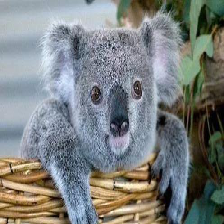

In [6]:
img_path = 'image_of_predict/Koalas.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img


In [ ]:
x = image.img_to_array(img)
x.shape

In [ ]:
x = np.expand_dims(x, axis=0)
x.shape

In [ ]:
np.max(x),np.min(x),np.mean(x)

In [ ]:
x = preprocess_input(x)

In [ ]:
np.max(x),np.min(x),np.mean(x)

In [ ]:
preds = model.predict(x)
preds

In [ ]:
np.argmax(preds)

In [ ]:
preds

In [ ]:

preds
print('Predicted:', decode_predictions(preds, 1))